In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, \
  Conv2D, BatchNormalization, ZeroPadding2D, MaxPooling2D, Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 16
batch_size = 128

In [4]:
!wget -nc https://archive.org/download/blood_cell_images/blood_cell_images.zip

--2024-05-01 06:51:07--  https://archive.org/download/blood_cell_images/blood_cell_images.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia601204.us.archive.org/14/items/blood_cell_images/blood_cell_images.zip [following]
--2024-05-01 06:51:07--  https://ia601204.us.archive.org/14/items/blood_cell_images/blood_cell_images.zip
Resolving ia601204.us.archive.org (ia601204.us.archive.org)... 207.241.227.134
Connecting to ia601204.us.archive.org (ia601204.us.archive.org)|207.241.227.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109834540 (105M) [application/zip]
Saving to: ‘blood_cell_images.zip’

blood_cell_images.z 100%[===================>] 104.75M  31.1MB/s    in 3.4s    

2024-05-01 06:51:11 (31.1 MB/s) - ‘blood_cell_images.zip’ saved [109834540/109834540]



In [5]:
!unzip -nq blood_cell_images.zip

In [6]:
!ls

blood_cell_images  blood_cell_images.zip  __MACOSX  sample_data


In [7]:
# https://www.kaggle.com/paultimothymooney/blood-cells
train_path = 'blood_cell_images/TRAIN'
valid_path = 'blood_cell_images/TEST'

In [8]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [9]:
# useful for getting number of classes
folders = glob(train_path + '/*')

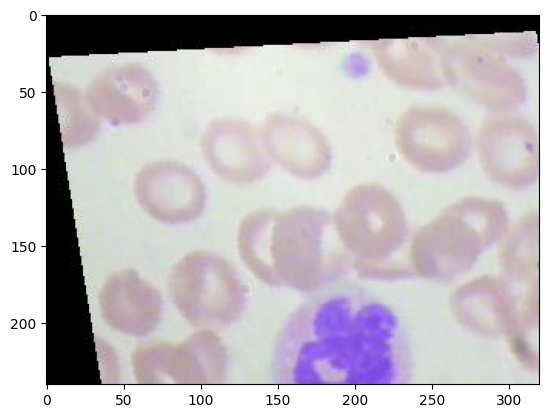

In [10]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [11]:
def identity_block(input_, kernel_size, filters):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1),
               kernel_initializer='he_normal'
    )(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same',
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1),
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)

    x = add([x, input_])
    x = Activation('relu')(x)
    return x

In [12]:
def conv_block(input_,
               kernel_size,
               filters,
               strides=(2, 2)):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1), strides=strides,
               kernel_initializer='he_normal'
    )(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same',
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1),
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(f3, (1, 1), strides=strides,
                      kernel_initializer='he_normal'
    )(input_)
    shortcut = BatchNormalization()(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [13]:
# our custom resnet
i = Input(shape=IMAGE_SIZE + [3])
x = ZeroPadding2D(padding=(3, 3))(i)
x = Conv2D(64, (7, 7),
           strides=(2, 2),
           padding='valid',
           kernel_initializer='he_normal'
           )(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256])
x = identity_block(x, 3, [64, 64, 256])

x = conv_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])

In [14]:
# our layers - you can add more if you want
x = Flatten()(x)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [15]:
# create a model object
model = Model(inputs=i, outputs=prediction)

In [16]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']          

In [17]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=Adam(learning_rate=0.0001),
  metrics=['accuracy']
)

In [18]:
# create an instance of ImageDataGenerator
def preprocess_input2(x):
  x /= 127.5
  x -= 1.
  return x

train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input2
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input2
)

In [19]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE, class_mode='sparse')
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


min: -1.0 max: 0.99215686


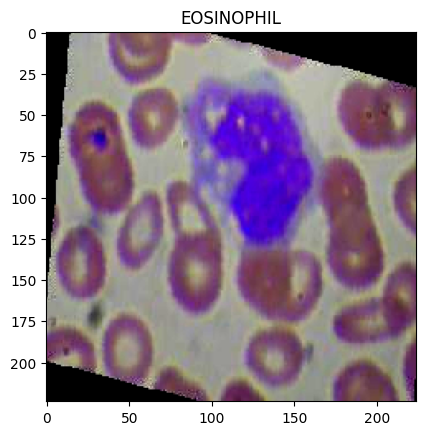

In [20]:
# should be NOT a strangely colored image
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [21]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [ ]:
# fit the model
checkpoint_filepath = '/tmp/checkpoint'
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
  callbacks=[
    tf.keras.callbacks.EarlyStopping(
      monitor='loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True),
  ]
)

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in val_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [ ]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

In [ ]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [ ]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')

In [ ]:
np.trace(cm) / cm.sum()

In [ ]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [ ]:
np.trace(valid_cm) / valid_cm.sum()